# Synthetic Regression Data Generation
## Objective

This notebook demonstrates how to systematically generate synthetic regression datasets for:

- Model benchmarking

- Controlled experiments

- Feature engineering validation

- Pipeline and preprocessing testing


The dataset is intentionally designed to include:

- Linear and non-linear effects

- Numerical and categorical features

- Interaction terms

- Noise and heteroskedasticity

- Business-inspired structure

## Why Synthetic Regression Data Matters

Synthetic data allows us to:

- Control the true data-generating process (DGP)

- Validate whether models learn real signal

- Test robustness to noise and complexity

- Avoid data leakage and privacy concerns

This notebook serves as a reference DGP for future notebooks across the repository.

# Imports and Global Configuration

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 2010
np.random.seed(RANDOM_STATE)


# Step 1 – Define Dataset Size

We explicitly parameterize dataset size to allow scalability testing.

In [3]:
N_SAMPLES = 5000

# Step 2 – Generate Numerical Features
Business Interpretation

- age: customer age

- income: annual income

- tenure: relationship length (years)

In [4]:
age = np.random.randint(18, 70, size=N_SAMPLES)

income = np.random.normal(
    loc=60000,
    scale=15000,
    size=N_SAMPLES
).clip(20000, 150000)

tenure = np.random.exponential(
    scale=5,
    size=N_SAMPLES
).clip(0, 30)


# Step 3 – Generate Categorical Features
Business Interpretation

- region: geographic market

- product_type: service tier

In [5]:
region = np.random.choice(
    ["North", "South", "East", "West"],
    size=N_SAMPLES,
    p=[0.25, 0.25, 0.30, 0.20]
)

product_type = np.random.choice(
    ["Basic", "Standard", "Premium"],
    size=N_SAMPLES,
    p=[0.4, 0.4, 0.2]
)


# Step 4 – Create Non-Linear and Interaction Effects

This step encodes true signal into the target.

## Business Logic Examples

- Income has diminishing returns

- Premium products amplify income impact

- Longer tenure increases value non-linearly

In [6]:
income_effect = 0.0008 * income
income_nonlinear = -0.000000004 * income**2

tenure_effect = 2.5 * np.log1p(tenure)

age_effect = 0.3 * age


## Categorical Effects

In [7]:
region_effect = pd.Series(region).map({
    "North": 10,
    "South": 0,
    "East": 5,
    "West": -5
}).values

product_effect = pd.Series(product_type).map({
    "Basic": 0,
    "Standard": 15,
    "Premium": 40
}).values


## Interaction: Income × Premium Product

In [8]:
premium_interaction = (
    (product_type == "Premium") * income * 0.0005
)


# Step 5 – Add Noise (Stochastic Component)

We add heteroskedastic noise, increasing with income.

In [9]:
noise = np.random.normal(
    loc=0,
    scale=5 + 0.0001 * income,
    size=N_SAMPLES
)


# Step 6 – Construct Target Variable
## Target Interpretation

customer_lifetime_value (continuous)

In [10]:
target = (
    50
    + income_effect
    + income_nonlinear
    + tenure_effect
    + age_effect
    + region_effect
    + product_effect
    + premium_interaction
    + noise
)


# Step 7 – Assemble Final Dataset

In [11]:
df = pd.DataFrame({
    "age": age,
    "income": income,
    "tenure": tenure,
    "region": region,
    "product_type": product_type,
    "customer_lifetime_value": target
})

df.head()


,age,income,tenure,region,product_type,customer_lifetime_value
0,19,35170.235384,6.054467,South,Standard,107.724559
1,24,87768.171955,11.248224,West,Premium,194.067305
2,44,59351.566328,2.306444,East,Premium,189.657615
3,31,60274.434067,12.877408,North,Basic,97.290966
4,31,42503.265350,4.912968,East,Standard,109.987914


# Step 8 – Quick Data Summary
## Distribution Overview

In [12]:
df.describe(include="all")

,age,income,tenure,region,product_type,customer_lifetime_value
count,5000.000000,5000.000000,5000.000000,5000,5000,5000.000000
unique,NaN,NaN,NaN,4,3,NaN
top,NaN,NaN,NaN,East,Standard,NaN
freq,NaN,NaN,NaN,1505,2003,NaN
mean,43.313800,60018.294450,5.164560,NaN,NaN,122.517228
std,14.866457,14751.435606,5.137277,NaN,NaN,29.978638
min,18.000000,20000.000000,0.000095,NaN,NaN,58.347934
25%,30.000000,50050.827461,1.489507,NaN,NaN,101.731911
50%,43.000000,59979.673637,3.523986,NaN,NaN,114.916583
75%,56.000000,70185.247097,7.106763,NaN,NaN,134.873708


##

## Target Distribution

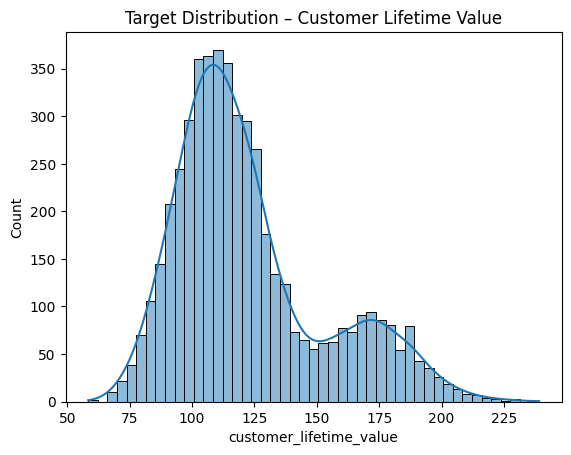

In [14]:
sns.histplot(df["customer_lifetime_value"], kde=True)
plt.title("Target Distribution – Customer Lifetime Value")
plt.show()

# Step 9 – Baseline Train/Test Split

In [15]:
X = df.drop(columns="customer_lifetime_value")
y = df["customer_lifetime_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)


# Step 10 – Baseline Preprocessing Pipeline

In [16]:
numeric_features = ["age", "income", "tenure"]
categorical_features = ["region", "product_type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# Step 11 – Baseline Models
## Linear Regression (Misspecified by Design)

In [17]:
linreg_pipeline = Pipeline(steps=[("preprocessing", preprocessor),
                                  ("model", LinearRegression())]
                          )

linreg_pipeline.fit(X_train, y_train)

y_pred_lr = linreg_pipeline.predict(X_test)

print("Linear Regression RMSE:",
      mean_squared_error(y_test, y_pred_lr, squared=False))
print("Linear Regression R²:",
      r2_score(y_test, y_pred_lr))

Linear Regression RMSE: 11.66085754014972
Linear Regression R²: 0.8459950961409243


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Random Forest (Closer to True DGP)

In [18]:
rf_pipeline = Pipeline(steps=[("preprocessing", preprocessor),
                              ("model", RandomForestRegressor(n_estimators=300,
                                                              random_state=RANDOM_STATE,
                                                              n_jobs=-1)
                              )]
                      )

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest RMSE:",
      mean_squared_error(y_test, y_pred_rf, squared=False))
print("Random Forest R²:",
      r2_score(y_test, y_pred_rf))

Random Forest RMSE: 12.162896881018172
Random Forest R²: 0.8324487700748702


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Step 12 – Interpretation of Results
Key Observations

- Linear regression underperforms due to:

     - Non-linear income effects

     - Interaction terms

- Tree-based models recover:

     - Non-linearities

     - Interactions

- This dataset is intentionally realistic, not trivial

# Step 13 – Reusability Notes

This dataset is suitable for:

- eature engineering demonstrations

- Model comparison benchmarks

- Pipeline testing

- Interpretability (SHAP, PDP)

- Imbalance, noise, and drift extensions

# __Summary__

This notebook established a controlled yet realistic regression data-generating process that:

- Mimics business-driven outcomes

- Includes structured complexity

- Serves as a reusable benchmark

It is the anchor notebook for all downstream modeling, preprocessing, evaluation, and deployment examples in this repository.